In [14]:
import sys
import matplotlib.pyplot as plt
import scanpy as sc
print(sys.executable)


/Users/dubingxue/opt/anaconda3/envs/smt/bin/python


In [2]:
import scanpy as sc
import numpy as np

adata_sp = sc.read_h5ad("BC_515_Section_1.h5ad")

adata_sp.layers["counts"] = adata_sp.X.copy()
adata_sp

AnnData object with n_obs × n_vars = 3508 × 15953
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'annotation'
    uns: 'msi', 'mz_features', 'orig.ident_colors', 'seurat_clusters_colors', 'spatial'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
    layers: 'log1p', 'raw', 'counts'

In [3]:
import tarfile, os

tar_path = "GSE176078_Wu_etal_2021_BRCA_scRNASeq.tar.gz"
out_dir = "GSE176078_scRNA"

os.makedirs(out_dir, exist_ok=True)

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(out_dir)

for root, dirs, files in os.walk(out_dir):
    level = root.replace(out_dir, "").count(os.sep)
    if level <= 2:
        print(root, "dirs:", len(dirs), "files:", len(files))
        for f in files[:10]:
            print("  ", f)


GSE176078_scRNA dirs: 1 files: 1
   .DS_Store
GSE176078_scRNA/Wu_etal_2021_BRCA_scRNASeq dirs: 0 files: 4
   count_matrix_barcodes.tsv
   metadata.csv
   count_matrix_sparse.mtx
   count_matrix_genes.tsv


In [4]:
import scanpy as sc
import pandas as pd
import scipy.io as sio
import scipy.sparse as sp
import numpy as np

ref_dir = "GSE176078_scRNA/Wu_etal_2021_BRCA_scRNASeq"

mtx_path  = f"{ref_dir}/count_matrix_sparse.mtx"
gene_path = f"{ref_dir}/count_matrix_genes.tsv"
bc_path   = f"{ref_dir}/count_matrix_barcodes.tsv"
meta_path = f"{ref_dir}/metadata.csv"

X = sio.mmread(mtx_path).tocsr()
print("Raw mtx shape:", X.shape)

genes = pd.read_csv(gene_path, header=None, sep="\t")
barcodes = pd.read_csv(bc_path, header=None, sep="\t")

genes_list = genes.iloc[:, 0].astype(str).values
bc_list = barcodes.iloc[:, 0].astype(str).values

if X.shape[0] == len(genes_list) and X.shape[1] == len(bc_list):
    X = X.T.tocsr()  
elif X.shape[0] == len(bc_list) and X.shape[1] == len(genes_list):
    pass  
else:
    raise ValueError(f"Shape mismatch: X={X.shape}, genes={len(genes_list)}, barcodes={len(bc_list)}")

adata_ref = sc.AnnData(X)
adata_ref.obs_names = bc_list
adata_ref.var_names = genes_list
adata_ref.var_names_make_unique()

meta = pd.read_csv(meta_path, index_col=0)
meta = meta.loc[adata_ref.obs_names.intersection(meta.index)]
adata_ref.obs = adata_ref.obs.join(meta, how="left")

print(adata_ref)
print("metadata columns:", adata_ref.obs.columns.tolist()[:30])


Raw mtx shape: (29733, 100064)
AnnData object with n_obs × n_vars = 100064 × 29733
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major'
metadata columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major']


In [5]:
adata_ref.obs["cell_type"] = adata_ref.obs["celltype_minor"].astype("category")
adata_ref.obs["cell_type"].value_counts().head(30)

T cells CD4+                   19231
T cells CD8+                   11487
Cancer LumA SC                  7742
Macrophage                      5929
Cancer Cycling                  5359
Endothelial ACKR1               4611
Cancer Basal SC                 4312
Cancer Her2 SC                  3708
Plasmablasts                    3524
PVL Differentiated              3487
CAFs myCAF-like                 3420
Cancer LumB SC                  3368
CAFs MSC iCAF-like              3153
B cells Memory                  2581
Monocyte                        2328
Luminal Progenitors             1992
PVL Immature                    1886
NK cells                        1846
Endothelial CXCL12              1644
Cycling T-cells                 1528
Mature Luminal                  1265
Endothelial RGS5                1147
NKT cells                       1122
Myoepithelial                   1098
DCs                              955
B cells Naive                    625
Cycling_Myeloid                  463
E

In [6]:
import scanpy as sc

adata_sp_use = adata_sp.copy()
adata_sp_use.X = adata_sp_use.layers["counts"].copy()

def prep(adata, n_hvg=2000):
    adata = adata.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, n_top_genes=n_hvg, flavor="seurat_v3")
    sc.pp.highly_variable_genes(adata, n_top_genes=n_hvg, flavor="seurat")

    return adata

In [7]:
adata_ref_p = prep(adata_ref, 2000)
adata_sp_p  = prep(adata_sp_use, 2000)

common = adata_ref_p.var_names.intersection(adata_sp_p.var_names)
adata_ref_p = adata_ref_p[:, common].copy()
adata_sp_p  = adata_sp_p[:, common].copy()

sc.pp.scale(adata_ref_p, max_value=2)
# sc.pp.scale(adata_ref_p)
sc.tl.pca(adata_ref_p)
# sc.pp.neighbors(adata_ref_p)
sc.pp.neighbors(adata_ref_p, n_neighbors=30, n_pcs=30, metric="cosine")

sc.tl.umap(adata_ref_p)

/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[<Axes: xlabel='spatial1', ylabel='spatial2'>]

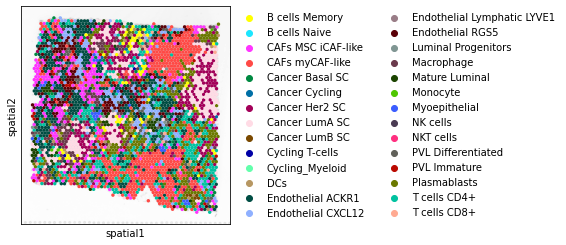

In [8]:

adata_ref_p.obs["cell_type"] = adata_ref.obs["cell_type"].reindex(adata_ref_p.obs_names).astype("category")

sc.tl.ingest(adata_sp_p, adata_ref_p, obs="cell_type")
adata_sp.obs["major_ingest"] = adata_sp_p.obs["cell_type"].astype(str)

adata_sp.obs["major_ingest"] = adata_sp.obs["major_ingest"].astype("category")

cats = list(adata_sp.obs["major_ingest"].cat.categories)

base = sc.pl.palettes.default_102
palette = {c: base[i % len(base)] for i, c in enumerate(cats)}

sc.pl.spatial(
    adata_sp,
    library_id="BC_515",
    img_key="hires",
    color="major_ingest",    
    size=1.5,
    palette=palette,
    alpha_img=0.6,
    bw=True,
    show=False,
    title=""
)


In [9]:
ct = adata_ref.obs["cell_type"].astype(str)

def to_ilc_state7(x: str) -> str:
    # -------------------------
    # Cancer states (3)
    # -------------------------
    if x in {"Cancer LumA SC", "Cancer LumB SC"}:
        return "Cancer LumA/B SC"

    if x in {"Cancer Basal SC", "Cancer Her2 SC"}:
        return "Cancer Basal/Her2 SC"

    if x == "Cancer Cycling":
        return "Cancer Cycling"

    # -------------------------
    # Immune (merged)
    # -------------------------
    if x in {
        "T cells CD4+", "T cells CD8+", "Cycling T-cells",
        "NK cells", "NKT cells",
        "Monocyte", "Macrophage", "DCs", "Cycling_Myeloid",
        "B cells Memory", "B cells Naive", "Plasmablasts"
    }:
        return "Immune"

    # -------------------------
    # Microenvironment
    # -------------------------
    if x in {"CAFs myCAF-like", "CAFs MSC iCAF-like"}:
        return "CAFs"

    if x in {
        "Endothelial ACKR1", "Endothelial CXCL12", "Endothelial RGS5",
        "Endothelial Lymphatic LYVE1",
        "PVL Differentiated", "PVL Immature", "Cycling PVL"
    }:
        return "Vascular"

    if x in {"Luminal Progenitors", "Mature Luminal", "Myoepithelial"}:
        return "Normal epithelial"

    raise ValueError(f"Unmapped cell_type: {x}")

LABEL7 = "cell_type_ilc_state7"
adata_ref.obs[LABEL7] = ct.map(to_ilc_state7).astype("category")

order7 = [
    "Cancer LumA/B SC",
    "Cancer Basal/Her2 SC",
    "Cancer Cycling",
    "CAFs",
    "Vascular",
    "Immune",
    "Normal epithelial"
]

adata_ref.obs[LABEL7] = (
    adata_ref.obs[LABEL7]
    .cat.set_categories(order7, ordered=True)
)

print("Reference ILC state (7 classes) counts:")
print(adata_ref.obs[LABEL7].value_counts())


Reference ILC state (7 classes) counts:
Immune                  51619
Vascular                13028
Cancer LumA/B SC        11110
Cancer Basal/Her2 SC     8020
CAFs                     6573
Cancer Cycling           5359
Normal epithelial        4355
Name: cell_type_ilc_state7, dtype: int64


In [23]:
LABEL = "cell_type_ilc_state7"
order = [
    "Cancer LumA/B SC",
    "Cancer Basal/Her2 SC",
    "Cancer Cycling",
    "CAFs",
    "Vascular",
    "Immune",
    "Normal epithelial"
]

adata_ref_p.obs[LABEL] = (
    adata_ref.obs[LABEL]
    .reindex(adata_ref_p.obs_names)
    .astype("category")
)
adata_ref_p.obs[LABEL] = adata_ref_p.obs[LABEL].cat.set_categories(order, ordered=True)

sc.tl.ingest(adata_sp_p, adata_ref_p, obs=LABEL)

OUTCOL = "major_ingest_ilc_state7"
adata_sp.obs[OUTCOL] = adata_sp_p.obs[LABEL].astype(str).astype("category")
adata_sp.obs[OUTCOL] = adata_sp.obs[OUTCOL].cat.set_categories(order, ordered=True)

print("Spatial ingested ILC state (7 classes) counts:")
print(adata_sp.obs[OUTCOL].value_counts())


/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Spatial ingested ILC state (7 classes) counts:
Vascular                962
Immune                  951
CAFs                    820
Cancer LumA/B SC        354
Cancer Basal/Her2 SC    326
Normal epithelial        89
Cancer Cycling            6
Name: major_ingest_ilc_state7, dtype: int64


In [24]:
anno_col = "annotation"              
ct_col   = "major_ingest_ilc_state7" 

cancer_states = {
    "Cancer LumA/B SC",
    "Cancer Basal/Her2 SC",
    "Cancer Cycling"
}

stroma_keep = {
    "CAFs",
    "Immune",
    "Vascular",
    "Normal epithelial"
}

def assign_final_label(anno, ct):
    if anno == "Tumor":
        return ct if ct in cancer_states else "Other (tumor region)"

    elif anno == "Stroma":
        return ct if ct in stroma_keep else "Other (stroma region)"

    else:
        return "Unlabelled"

adata_sp.obs["final_region"] = [
    assign_final_label(a, c)
    for a, c in zip(adata_sp.obs[anno_col], adata_sp.obs[ct_col])
]
adata_sp.obs["final_region"] = adata_sp.obs["final_region"].astype("category")

# 快速检查
import pandas as pd
print(pd.crosstab(adata_sp.obs[anno_col], adata_sp.obs["final_region"]))


final_region  CAFs  Cancer Basal/Her2 SC  Cancer Cycling  Cancer LumA/B SC  \
annotation                                                                   
Stroma         705                     0               0                 0   
Tumor            0                   166               3               237   
Unlabelled       0                     0               0                 0   

final_region  Immune  Normal epithelial  Other (stroma region)  \
annotation                                                       
Stroma           730                 82                    259   
Tumor              0                  0                      0   
Unlabelled         0                  0                      0   

final_region  Other (tumor region)  Unlabelled  Vascular  
annotation                                                
Stroma                           0           0       931  
Tumor                          318           0         0  
Unlabelled                       0        

In [25]:
pd.crosstab(adata_sp.obs["annotation"], adata_sp.obs["final_region"])

final_region,CAFs,Cancer Basal/Her2 SC,Cancer Cycling,Cancer LumA/B SC,Immune,Normal epithelial,Other (stroma region),Other (tumor region),Unlabelled,Vascular
annotation,,,,,,,,,,
Stroma,705,0,0,0,730,82,259,0,0,931
Tumor,0,166,3,237,0,0,0,318,0,0
Unlabelled,0,0,0,0,0,0,0,0,77,0


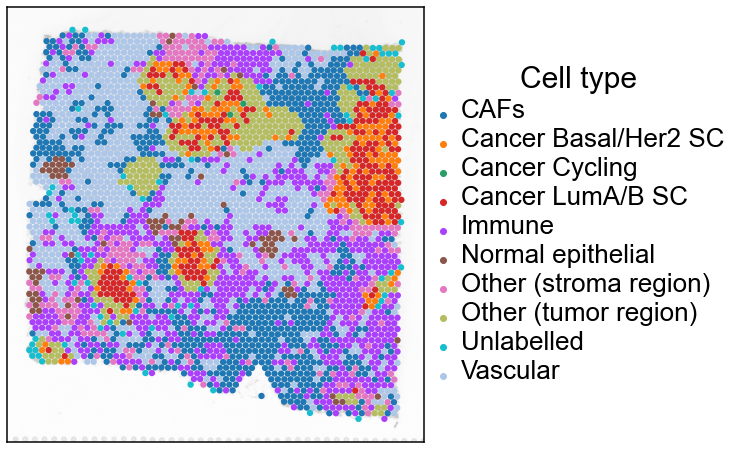

In [26]:
palette = sc.pl.palettes.default_20[:10]

fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.spatial(
    adata_sp,
    color="final_region",
    library_id='BC_515',
    img_key='hires',
    palette=palette,
    size=1.4,
    bw=True,
    alpha_img=0.6,
    ax=ax,
    show=False,
    legend_loc='right margin',
    legend_fontsize='medium',
    title=""
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')
    
legend = ax.get_legend()
if legend is not None:
    legend.set_title("Cell type")
    legend.get_title().set_fontsize(30)
    legend.get_title().set_fontfamily("Arial")

    for text in legend.get_texts():
        text.set_fontsize(26)
        text.set_fontfamily("Arial")

plt.savefig('spatial_final_region.svg', format='svg', bbox_inches='tight')

plt.show()


In [27]:
adata_sp.obs["final_label"] = adata_sp.obs["final_region"].astype(str)
import pandas as pd

df_labels = adata_sp.obs[["final_label"]].copy()
df_labels["spot"] = df_labels.index   

df_labels.to_csv("spatial_final_labels.csv", index=False)